In [1]:
from cpymad.madx import Madx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import stats
from scipy.optimize import least_squares as ls
from scipy.optimize import minimize as som

from scipy.optimize import fmin_cobyla


from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


# standard configurations
#get_ipython().magic('matplotlib inline')
#%config InlineBackend.figure_format = 'retina' # retina display

# in order to have fancy plots with lattice
def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

# Home-made truncated gaussian distribution
def trun_norm(cut):
    x = np.random.normal()
    return x+cut if np.abs(x)<cut else trun_norm(cut)


from matplotlib import rc

#rc('text', usetex=False)
rc('text', usetex=True)
rc('font', serif ='Times')
rc('font', size=16)
rc('axes', linewidth=0.5)
rc('lines', linewidth=1.15)
rc('figure', figsize=(8.3,5.2))
rc('grid', c='0.5', ls='--', lw=0.5)

/home/dmitrii/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# constraint for cobyla here
def con1(x):
    return 0.05*np.sqrt(2)-np.sum(x**2)
    

#=========================================================================================

# scalar function, it is the characterization of full X-orbit
# The argument is numpy array (list of kickers), len = 8
# returns dx/dk
def find_gradient_x(theta,flag):

    
    kf0 =1/30/5
    kd0 =-1/30/5-1/30/5/100
    delta = kf0/10

    a=madx.input('''kf ={}; kd ={};
    kn0_corr_00 := {};
    kn0_corr_01 := {};
    kn0_corr_10 := {};
    kn0_corr_11 := {};
    kn0_corr_20 := {};
    kn0_corr_21 := {};
    kn0_corr_30 := {};
    kn0_corr_31 := {};
    kn0_corr_40 := {};
    kn0_corr_41 := {};
    kn0_corr_50 := {};
    kn0_corr_51 := {}; 

    ;twiss;'''.format(kf0,kd0,*theta));

    aux=madx.table.twiss.dframe()
    xbpm0 =aux[aux["keyword"]=="monitor"]["x"]

    madx.input('''kf ={}; kd ={};twiss;'''.format(kf0+delta,kd0+delta));

    aux=madx.table.twiss.dframe()
    xbpm = aux[aux["keyword"]=="monitor"]["x"]

    vec = np.array(xbpm-xbpm0)/delta

    return np.linalg.norm(vec) if flag == True else vec 


#=========================================================================================



def find_orb_x(theta,flag):
    
    madx.input('''
    kf ={}; kd ={};
    select,flag=interpolate, class=quadrupole, slice=1, range=#s/#e;
    '''.format(1/30/5, -1/30/5-1/30/5/100))
      
    madx.input('''
    kn0_corr_00 := {};
    kn0_corr_01 := {};
    kn0_corr_10 := {};
    kn0_corr_11 := {};
    kn0_corr_20 := {};
    kn0_corr_21 := {};
    kn0_corr_30 := {};
    kn0_corr_31 := {};
    kn0_corr_40 := {};
    kn0_corr_41 := {};
    kn0_corr_50 := {};
    kn0_corr_51 := {};    
    twiss;
    '''.format(*theta));
    
    aux=madx.table.twiss.dframe()
    xq =aux[aux["keyword"]=="quadrupole"]["x"]
    
    aux =madx.table.efield.dframe()
    Qerr = aux[aux["name"].str.contains("q")]
    
    vec = np.array(np.array(xq)-np.array(Qerr["dx"]))
#    print(vec)

    return np.linalg.norm(vec) if flag == True else vec 


def periodic_beta(theta):
    
    madx.input('''
    kn1_corr_00 :={};
    kn1_corr_10 :={};
    kn1_corr_20 :={};
    kn1_corr_30 :={};
    kn1_corr_40 :={};
    kn1_corr_50 :={};
    
    kn1_corr_01 :={};
    kn1_corr_11 :={};
    kn1_corr_21 :={};
    kn1_corr_31 :={};
    kn1_corr_41 :={};
    kn1_corr_51 :={};
      
    twiss;'''.format(*theta) );
    
    aux = madx.table.twiss.dframe()
    tmp=aux[aux["keyword"]=="monitor"]

    metric_x = (tmp["betx"].max()-tmp["betx"].min())*tmp["betx"].std()
    metric_y = (tmp["bety"].max()-tmp["bety"].min())*tmp["bety"].std()
    
    if np.abs(metric_x - metric_y) > np.max([metric_x,metric_y]):
        if metric_x < metric_y:
            metric = 2*metric_y
        else:
            metric = 2*metric_x
    else:
        metric = metric_x+metric_y
    
    return metric
  

In [98]:
myString1 = '''
addquaderr(dx_err,dy_err,g1,g2,quadname): macro = {
rErr1n:=3e-4;
rErr1s:=1e-4;

SELECT, FLAG=error, clear;
eoption, add=false;
SELECT, FLAG=error, PATTERN="quadname";
EALIGN, DX:=0.0007*(dx_err-2.5), DY:=0.0007*(dy_err-2.5);
EFCOMP, radius=0.03, order = 0,
    dknr:={0,rErr1n*(g1-2.5)},
    dksr:={0,rErr1s*(g2-2.5)};
};

'''

myString2 = '''
// Make thin

SELECT, FLAG=makethin,CLASS=QUADRUPOLE,SLICE=2;
//SELECT, FLAG=makethin,CLASS=DRIFT,SLICE=2;
makethin, STYLE=TEAPOT, sequence = FODO;
use,sequence=FODO;
twiss;
'''

myString3 = '''
match, sequence=FODO;
vary,name=kf;
vary,name=kd;
global, sequence=FODO, Q1=1.84,Q2=1.73;
lmdif,calls=2000,tolerance=1.0e-8;
endmatch;
twiss;
'''

In [99]:
madx = Madx()
madx.input(myString)
madx.input(myString3)
madx.input(myString2)
madx.input(myString3)
madx.input("SAVE, SEQUENCE=FODO,FILE=FODO_THIN.seq")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.09.09 18:27:38      +
  ++++++++++++++++++++++++++++++++++++++++++++
! *********************************************************************

! Definition of parameters

! *********************************************************************



l_cell=100;

quadrupoleLenght=5;

f=30;

//kf:=1/f/quadrupoleLenght;// m^-2

//kd:=-kf*101/100;// m^-2



kf:=6.77407e-03;

kd:=-6.54921e-03;



kn0_corr_00 := 0;

kn0_corr_01 := 0;

kn0_corr_10 := 0;

kn0_corr_11 := 0;

kn0_corr_20 := 0;

kn0_corr_21 := 0;

kn0_corr_30 := 0;

kn0_corr_31 := 0;

kn0_corr_40 := 0;

kn0_corr_41 := 0;

kn0_corr_50 := 0;

kn0_corr_51 := 0;



kn1_corr_00 :=0;

kn1_corr_01 :=0;

kn1_corr_10 :=0;

kn1_corr_11 :=0;

kn1_corr_20 :=0;

kn1_corr_21 :=0;

kn1_corr_30 :=0;

kn1_corr_31 :=0;

kn1_corr_40 :=0;

kn1_

True

In [95]:
myString='''
CALL, FILE = "FODO_thick.lat";
'''

myString1='''
CALL, FILE = "fodo_thin.seq";
beam, particle=proton, energy=2;
use, sequence=FODO;
twiss;
'''



In [72]:
# this method applies errors to the lattice
# note, that all correctors are set to zero here
# myString
def add_err():

    dxdy = [trun_norm(2.5) for i in range(2*4*6)]
    
#    madx.input(myString)
#    aux = madx.table.twiss.dframe()


    out =madx.input('''
    kn0_corr_00 = 0;
    kn0_corr_01 = 0;
    kn0_corr_10 = 0;
    kn0_corr_11 = 0;
    kn0_corr_20 = 0;
    kn0_corr_21 = 0;
    kn0_corr_30 = 0;
    kn0_corr_31 = 0;
    kn0_corr_40 = 0;
    kn0_corr_41 = 0;
    kn0_corr_50 = 0;
    kn0_corr_51 = 0; 
    
    kn1_corr_00 =0;
    kn1_corr_10 =0;
    kn1_corr_20 =0;
    kn1_corr_30 =0;
    kn1_corr_40 =0;
    kn1_corr_50 =0;
    kn1_corr_01 =0;
    kn1_corr_11 =0;
    kn1_corr_21 =0;
    kn1_corr_31 =0;
    kn1_corr_41 =0;
    kn1_corr_51 =0;
    
    exec, addquaderr({},{},{},{},QF0);
    exec, addquaderr({},{},{},{},QD0);

    exec, addquaderr({},{},{},{},QF1);
    exec, addquaderr({},{},{},{},QD1);

    exec, addquaderr({},{},{},{},QF2);
    exec, addquaderr({},{},{},{},QD2);

    exec, addquaderr({},{},{},{},QF3);
    exec, addquaderr({},{},{},{},QD3);

    exec, addquaderr({},{},{},{},QF4);
    exec, addquaderr({},{},{},{},QD4);

    exec, addquaderr({},{},{},{},QF5);
    exec, addquaderr({},{},{},{},QD5);


    SELECT, FLAG = ERROR, FULL;
    ESAVE, FILE = err.txt;

    twiss;

    '''.format(*dxdy))
    return out



In [96]:
#madx = Madx(stdout=False)
madx = Madx()
madx.input(myString)
madx.input(myString3)

aux1 =madx.table.twiss.dframe()
madx.input(myString1)
aux2 =madx.table.twiss.dframe()



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.09.09 18:26:53      +
  ++++++++++++++++++++++++++++++++++++++++++++
! *********************************************************************

! Definition of parameters

! *********************************************************************



l_cell=100;

quadrupoleLenght=5;

f=30;

//kf:=1/f/quadrupoleLenght;// m^-2

//kd:=-kf*101/100;// m^-2



kf:=6.77407e-03;

kd:=-6.54921e-03;



kn0_corr_00 := 0;

kn0_corr_01 := 0;

kn0_corr_10 := 0;

kn0_corr_11 := 0;

kn0_corr_20 := 0;

kn0_corr_21 := 0;

kn0_corr_30 := 0;

kn0_corr_31 := 0;

kn0_corr_40 := 0;

kn0_corr_41 := 0;

kn0_corr_50 := 0;

kn0_corr_51 := 0;



kn1_corr_00 :=0;

kn1_corr_01 :=0;

kn1_corr_10 :=0;

kn1_corr_11 :=0;

kn1_corr_20 :=0;

kn1_corr_21 :=0;

kn1_corr_30 :=0;

kn1_corr_31 :=0;

kn1_corr_40 :=0;

kn1_

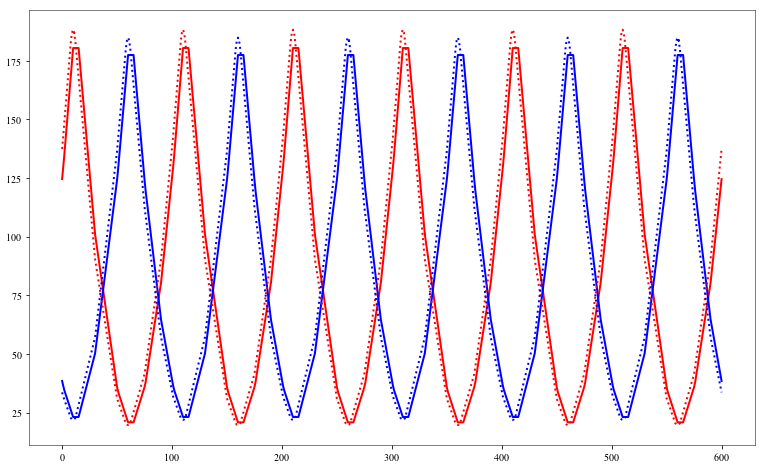

In [97]:
fig = plt.figure(figsize=(13,8))

plt.plot(aux1['s'],aux1['betx'],'r', lw=2)
plt.plot(aux1['s'],aux1['bety'],'b', lw=2)

plt.plot(aux2['s'],aux2['betx'],'r',ls=":", lw=2)
plt.plot(aux2['s'],aux2['bety'],'b',ls=":", lw=2)

In [64]:
madx.input(myString2)
madx.input(myString3)
#madx.input("SAVE, SEQUENCE=FODO,FILE=FODO_THIN.seq")

makethin: style chosen : teapot
makethin: slicing sequence : fodo
enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
               600                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       1.839999999       -3.044469858        188.1680344                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0        1.730000001 

               dq2            betymax              dymax              dyrms 
      -2.821149282        184.7902731                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0     

True

In [60]:
myTwiss = madx.table.twiss.dframe()

a=add_err()
print(a)

DF0=madx.table.twiss.dframe()
bpmDF0 = DF0[DF0["keyword"]=="monitor"]
qsPos = DF0[DF0["keyword"]=="quadrupole"]

err =madx.table.efield.dframe()
qsERR = err[err["name"].str.contains("q")]


bpms = list(myTwiss[myTwiss["keyword"]=="monitor"]["name"])
other =["n", "dx(q)"]
corrs = ["kn0_corr_{}{}".format(i//2,i%2) for i in range(12)]

cols = bpms+other+corrs

df = pd.read_csv("inverse_regression.csv")

max_depth = 3
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=20,max_depth=max_depth, random_state=10))

feature_cols = bpms
target_cols = corrs

A = np.linalg.norm(df[target_cols])
X = df[feature_cols]
Y = df[target_cols]/A
n = len(df)
#print(n)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=int(8*n/10), test_size=n-int(8*n/10), random_state=1)

regr_multirf.fit(X_train, Y_train)
y_multirf = regr_multirf.predict(X_test)

++++++ info: kn0_corr_00 redefined
++++++ info: kn0_corr_01 redefined
++++++ info: kn0_corr_10 redefined
++++++ info: kn0_corr_11 redefined
++++++ info: kn0_corr_20 redefined
++++++ info: kn0_corr_21 redefined
++++++ info: kn0_corr_30 redefined
++++++ info: kn0_corr_31 redefined
++++++ info: kn0_corr_40 redefined
++++++ info: kn0_corr_41 redefined
++++++ info: kn0_corr_50 redefined
++++++ info: kn0_corr_51 redefined
++++++ info: kn1_corr_00 redefined
++++++ info: kn1_corr_10 redefined
++++++ info: kn1_corr_20 redefined
++++++ info: kn1_corr_30 redefined
++++++ info: kn1_corr_40 redefined
++++++ info: kn1_corr_50 redefined
++++++ info: kn1_corr_01 redefined
++++++ info: kn1_corr_11 redefined
++++++ info: kn1_corr_21 redefined
++++++ info: kn1_corr_31 redefined
++++++ info: kn1_corr_41 redefined
++++++ info: kn1_corr_51 redefined
Assigned alignment errors to 11 elements
Assigned field errors to 10 elements
++++++ info: rerr1n redefined
++++++ info: rerr1s redefined
Assigned alignment err

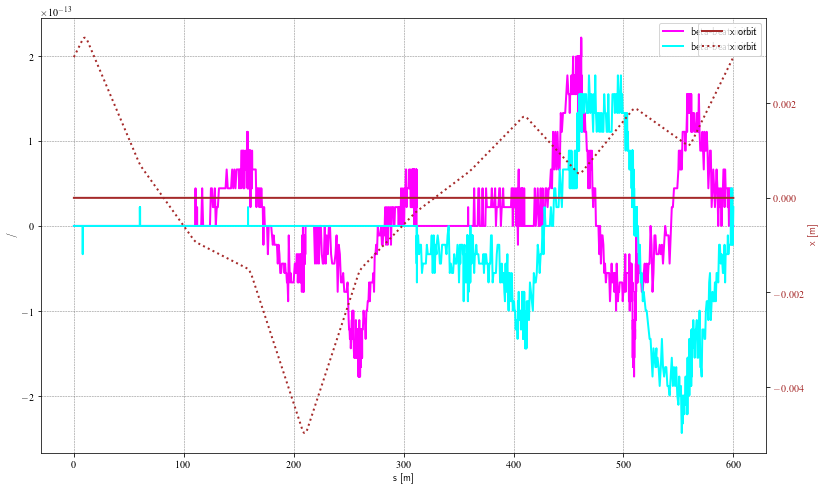

In [55]:
# just plotting
fig = plt.figure(figsize=(13,8))

plt.plot(DF0['s'],(DF0['betx']/myTwiss['betx']-1)*100,'magenta', label='beta-beat initial', lw=2)
plt.plot(DF0['s'],(DF0['bety']/myTwiss['bety']-1)*100,'cyan', label='beta-beat initial', lw=2)

#plt.plot(myTwiss['s'],myTwiss['betx'],'b', label='$\\beta_x$')
#plt.plot(myTwiss['s'],myTwiss['bety'],'r', label='$\\beta_y$')
#plt.plot(DF0['s'],DF0['betx'],'b', label='$\\beta_x$', ls=":")
#plt.plot(DF0['s'],DF0['bety'],'r', label='$\\beta_y$', ls=":")
#plt.ylabel('[m]')
plt.ylabel('/%')
plt.xlabel('s [m]')
plt.legend(loc='best')

plt.grid()

ax3 = plt.gca().twinx() 
plt.plot(myTwiss['s'],myTwiss['x'],'brown', label='x orbit', lw=2)
plt.plot(DF0['s'],DF0['x'],'brown', label='x orbit', lw=2, ls=":")
#plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")


ax3.set_ylabel('x [m]', color='brown')
ax3.tick_params(axis='y', labelcolor='brown')
plt.legend(loc='best')
#plt.ylim(0, 10);

In [8]:
options_dict = {'rhobeg': 5*10**(-7), 'disp': True}
cons = [{"type": "ineq", "fun": con1}]

dxdk0 =find_gradient_x(np.zeros(12), False)
vec_predict = regr_multirf.predict([dxdk0])*A

vec_xg_dt = som(find_gradient_x, vec_predict[0], method="COBYLA", constraints=cons, options=options_dict,args=(True,))

vec_xg = som(find_gradient_x, np.zeros(12), method="COBYLA", constraints=cons, options=options_dict,args=(True,))
vec_xo = som(find_orb_x, np.zeros(12), method="COBYLA", constraints=cons, options=options_dict,args=(True,))

In [9]:
madx.input('''
kn0_corr_00 := {};kn0_corr_01 := {};kn0_corr_10 := {};kn0_corr_11 := {};kn0_corr_20 := {};kn0_corr_21 := {};
kn0_corr_30 := {};kn0_corr_31 := {};kn0_corr_40 := {};kn0_corr_41 := {};kn0_corr_50 := {};kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
twiss;'''.format(*vec_predict[0]));

DF=madx.table.twiss.dframe()

madx.input('''
kn0_corr_00 := {};kn0_corr_01 := {};kn0_corr_10 := {};kn0_corr_11 := {};kn0_corr_20 := {};kn0_corr_21 := {};
kn0_corr_30 := {};kn0_corr_31 := {};kn0_corr_40 := {};kn0_corr_41 := {};kn0_corr_50 := {};kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
twiss;'''.format(*vec_xg_dt.x));

DF1=madx.table.twiss.dframe()
bpmDF1 = DF1[DF1["keyword"]=="hmonitor"]


madx.input('''
kn0_corr_00 := {};kn0_corr_01 := {};kn0_corr_10 := {};kn0_corr_11 := {};kn0_corr_20 := {};kn0_corr_21 := {};
kn0_corr_30 := {};kn0_corr_31 := {};kn0_corr_40 := {};kn0_corr_41 := {};kn0_corr_50 := {};kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
twiss;'''.format(*vec_xo.x));

DF2=madx.table.twiss.dframe()

madx.input('''
kn0_corr_00 := {};kn0_corr_01 := {};kn0_corr_10 := {};kn0_corr_11 := {};kn0_corr_20 := {};kn0_corr_21 := {};
kn0_corr_30 := {};kn0_corr_31 := {};kn0_corr_40 := {};kn0_corr_41 := {};kn0_corr_50 := {};kn0_corr_51 := {};    
select,flag=interpolate, class=drift, slice=20, range=#s/#e;
twiss;'''.format(*vec_xg.x));

DF3=madx.table.twiss.dframe()



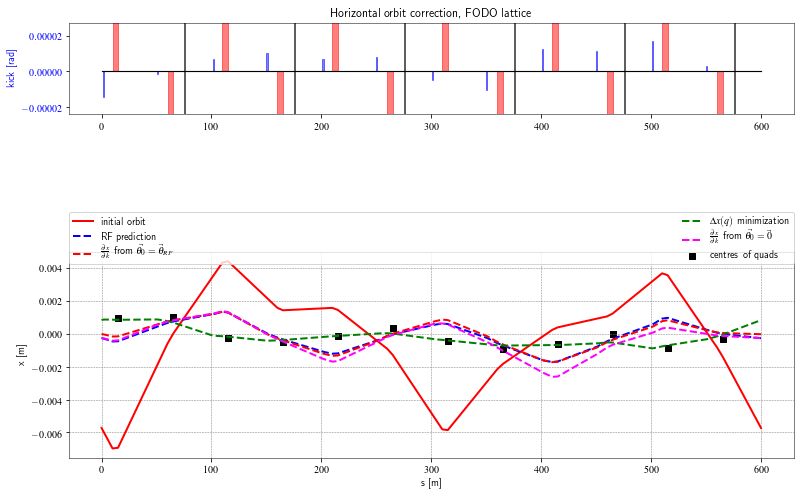

In [10]:
# plotting
#fig = plt.figure()
fig = plt.figure(figsize=(13,8))

fig.subplots_adjust(hspace=0.25)
ax1=plt.subplot2grid((4,3), (0,0), colspan=3, rowspan=1)
ax1.set_title("Horizontal orbit correction, FODO lattice")
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

tmp=DF1[DF1['keyword']=='quadrupole']
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

hk = []
tmp=DF1[(DF1['keyword']=='hkicker')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.hkick, v_offset=aux.hkick/2, color='blue')
    hk.append(aux.hkick)
    color = 'red'

tmp=DF1[(DF1['keyword']=='monitor')]
for i in range(len(tmp)):
    aux=tmp.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=0.005, color='black')
    plotLatticeSeries(plt.gca(),aux, height=0.01, v_offset=-0.005, color='black')
    color = 'blue'

    
#ax1.set_ylabel(r'hkick [$\delta p_y /p_0$]', color=color)
ax1.set_ylabel(r'kick [rad]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(min(hk)-10**(-5),max(hk)+10**(-5))

axbeta=plt.subplot2grid((4,3), (2,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(DF0['s'],DF0['x'],'r', label='initial orbit', lw=2)
plt.plot(DF['s'],DF['x'],'blue',ls="--", label='RF prediction', lw=2)
plt.plot(DF1['s'],DF1['x'],'red',ls="--", label=r'$\frac{\partial x}{\partial k}$ from $\vec{\theta_0}=\vec{\theta}_{RF}$', lw=2)
plt.plot(DF2['s'],DF2['x'],'green',ls="--", label=r'$\Delta x(q)$ minimization', lw=2)
plt.plot(DF3['s'],DF3['x'],'magenta',ls="--", label=r'$\frac{\partial x}{\partial k}$ from $\vec{\theta_0}=\vec{0}$', lw=2)
plt.scatter(qsPos.s,qsERR.dx, label="centres of quads", marker = "s", color = "black")

#plt.ylim([-0.03,0.04])

#plt.scatter(bpmDF1.s,bpmDF1.x, color = "red", s = 50, marker="x", label="bpm final")

#plt.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend(bbox_to_anchor=(0., 0.94, 1., .01), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
#l1 =plt.legend([p1,p2,p3],['initial orbit','RF prediction','dx/dk from RF prediction'], loc=1)
#l2 =plt.legend([p4,p5,p6],['dx(q) minimization','dx/dk from zero',"centres of quads"], loc=4)
#plt.gca().add_artist(l1)


plt.ylabel('x [m]')
plt.xlabel('s [m]')
plt.grid()

#plt.savefig("FODO_corr.pdf")

In [11]:
theta = np.zeros(12)
#theta = np.random.normal(0,10**(-6),12)
periodic_beta(theta)
options_dict = {'rhobeg': 10**(-5), 'disp': True}
vec_beta_per = som(periodic_beta, theta, method="COBYLA", constraints=cons, options=options_dict)


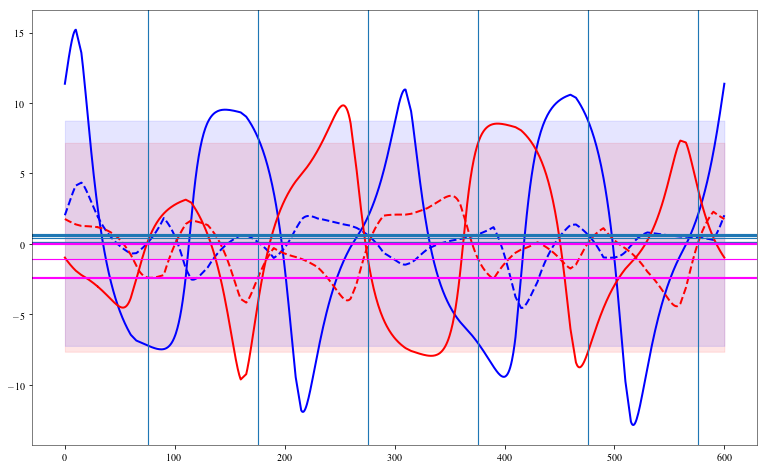

In [12]:
madx.input('''
kn1_corr_00 :={};
kn1_corr_10 :={};
kn1_corr_20 :={};
kn1_corr_30 :={};
kn1_corr_40 :={};
kn1_corr_50 :={};
    
kn1_corr_01 :={};
kn1_corr_11 :={};
kn1_corr_21 :={};
kn1_corr_31 :={};
kn1_corr_41 :={};
kn1_corr_51 :={};
twiss;'''.format(*vec_beta_per.x) );

DF1 = madx.table.twiss.dframe()

fig = plt.figure(figsize=(13,8))

DF1 = madx.table.twiss.dframe()
plt.plot(DF0['s'],(DF0['bety']/myTwiss['bety']-1)*100,'b', label='beta-beat initial', lw=2)
plt.plot(DF1['s'],(DF1['bety']/myTwiss['bety']-1)*100,'b', label='beta-beat model', lw=2, ls="--")

plt.plot(DF0['s'],(DF0['betx']/myTwiss['betx']-1)*100,'r', label='beta-beat initial', lw=2)
plt.plot(DF1['s'],(DF1['betx']/myTwiss['betx']-1)*100,'r', label='beta-beat model', lw=2, ls="--")

bpm_ini = myTwiss[myTwiss["keyword"]=="monitor"]
bpm_fin = DF1[DF1["keyword"]=="monitor"]

bx0max =np.max(DF0[DF0["keyword"]=="monitor"]['betx']/bpm_ini['betx']-1)*100
bx0min =np.min(DF0[DF0["keyword"]=="monitor"]['betx']/bpm_ini['betx']-1)*100
by0max =np.max(DF0[DF0["keyword"]=="monitor"]['bety']/bpm_ini['bety']-1)*100
by0min =np.min(DF0[DF0["keyword"]=="monitor"]['bety']/bpm_ini['bety']-1)*100

plt.fill_between(DF0["s"],y1=[bx0max for x in DF0["s"]],y2=[bx0min for x in DF0["s"]], color = "r", alpha=0.1)
plt.fill_between(DF0["s"],y1=[by0max for x in DF0["s"]],y2=[by0min for x in DF0["s"]], color = "b", alpha=0.1)

[plt.axvline(x) for x in DF0[DF0["keyword"]=="monitor"]['s']]
[plt.axhline(x) for x in (bpm_fin['bety']/bpm_ini['bety']-1)*100]
[plt.axhline(x, color = "magenta") for x in (bpm_fin['betx']/bpm_ini['betx']-1)*100]
plt.show()

In [135]:
opt_dict = {'rhobeg': .00001, 'disp': True}

#dxdk_start, dxdk_mrf, dxdk_rf, dxdk_zero, dxdk_fin, dxdk_quads = [],[],[],[],[],[]
#dxq_start, dxq_mrf, dxq_rf, dxq_zero, dxq_fin, dxq_quads = [],[],[],[],[],[]
#n_zero, n_fin, n_quads = [],[],[]

for i in range(50):

    add_err()
    DF0=madx.table.twiss.dframe()
    x0 = np.array(DF0[DF0["keyword"]=="hmonitor"]["x"])[0]
    dxdk0 =find_gradient_x(np.zeros(2))
    dx0 = find_orb_x(np.zeros(2))
    
    dxdk_start.append(dxdk0)
    dxq_start.append(dx0)
    

    vec_predict_mrf = regr_multirf.predict([[x0,dxdk0]])[0]*A
    dxdk_mrf.append(find_gradient_x(vec_predict_mrf))
    dxq_mrf.append(find_orb_x(vec_predict_mrf))    

    vec_predict_rf = regr_rf.predict([[x0,dxdk0]])[0]*A
    dxdk_rf.append(find_gradient_x(vec_predict_rf))
    dxq_rf.append(find_orb_x(vec_predict_rf))    
    
    
    
    vec_xg_dt = som(find_gradient_x, vec_predict_rf, method="COBYLA", constraints=cons, options=opt_dict)
    dxdk_fin.append(find_gradient_x(vec_xg_dt.x))
    dxq_fin.append(find_orb_x(vec_xg_dt.x)) 
    n_fin.append(vec_xg_dt.nfev)
    
    vec_xg = som(find_gradient_x, np.zeros(2), method="COBYLA", constraints=cons, options=opt_dict)
    dxdk_zero.append(find_gradient_x(vec_xg.x))
    dxq_zero.append(find_orb_x(vec_xg.x))
    n_zero.append(vec_xg.nfev)

    vec_xo = som(find_orb_x, np.zeros(2), method="COBYLA", constraints=cons, options=opt_dict)
    dxdk_quads.append(find_gradient_x(vec_xo.x))
    dxq_quads.append(find_orb_x(vec_xo.x))    
    n_quads.append(vec_xo.nfev)
    



In [136]:
df2 = pd.DataFrame(columns=["type","final dx/dk","final dx(q)", "opt. steps"])

df2 = df2.append({"type":"zero","final dx/dk":np.mean(dxdk_start),"final dx(q)":np.mean(dxq_start), "opt. steps":0}, ignore_index=True)
df2 = df2.append({"type":"mrf prediction","final dx/dk":np.mean(dxdk_mrf),"final dx(q)":np.mean(dxq_mrf), "opt. steps":1}, ignore_index=True)
df2 = df2.append({"type":"rf prediction","final dx/dk":np.mean(dxdk_rf),"final dx(q)":np.mean(dxq_rf), "opt. steps":1}, ignore_index=True)
df2 = df2.append({"type":"dx/dk from rf prediction","final dx/dk":np.mean(dxdk_fin),"final dx(q)":np.mean(dxq_fin), "opt. steps":int(np.mean(n_fin))}, ignore_index=True)
df2 = df2.append({"type":"dx/dk from zero","final dx/dk":np.mean(dxdk_zero),"final dx(q)":np.mean(dxq_zero), "opt. steps":int(np.mean(n_zero))}, ignore_index=True)
df2 = df2.append({"type":"dx(q) from zero","final dx/dk":np.mean(dxdk_quads),"final dx(q)":np.mean(dxq_quads), "opt. steps":int(np.mean(n_quads))}, ignore_index=True)

df2

,type,final dx/dk,final dx(q),opt. steps
0,zero,2.504634,0.014188,0
1,mrf prediction,1.201575,0.007208,1
2,rf prediction,1.225661,0.007114,1
3,dx/dk from rf prediction,0.139587,0.003774,13
4,dx/dk from zero,0.143209,0.006786,23
5,dx(q) from zero,0.193952,0.002631,92


In [ ]:
def make_train_data():

    df_tmp = pd.DataFrame(columns=cols)

    for i in range(100):
        a = add_err()
        if a[0]:
            dxdk0 =find_gradient_x(np.zeros(len(corrs)), False)
       
            tmp =dict()
            for i,x in enumerate(dxdk0):
                tmp[bpms[i]]=x
              
            theta_x = np.zeros(len(corrs))

            vec = som(find_orb_x, theta_x, method="COBYLA", constraints=cons, options=opt, args=(True,))

            for i,x in enumerate(vec.x):
                tmp[corrs[i]]=x
        
#            tmp["dx/dk(0)"]= dxdk0
            tmp["n"]= vec.nfev
            tmp["dx(q)"]= vec.fun
        
            #this step is required to indetify, where the optimizer found totally wrong sollution
            if np.linalg.norm(dxdk0) > find_gradient_x(vec.x,True):
                df_tmp =df_tmp.append(tmp,ignore_index=True)
            else:
                print("warn! the optimum sollution not found")
            
    return df_tmp

#df = make_train_data()
#df.to_csv("inverse_regression.csv",index=False)


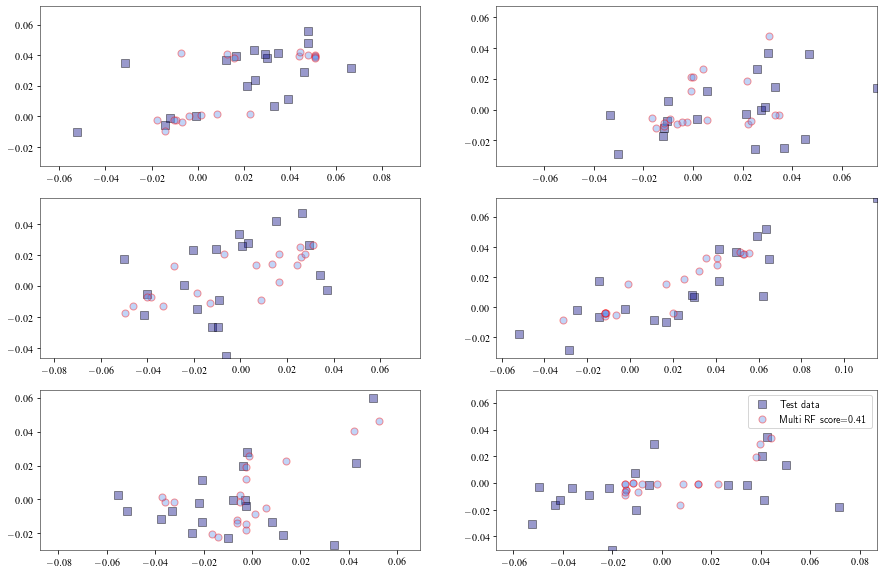

In [54]:
fig, axs = plt.subplots(3, 2)
fig.set_figheight(10)
fig.set_figwidth(15)

s = 50
a = 0.4

[axs[i//2,i%2].scatter(Y_test[corrs[2*i]],Y_test[corrs[2*i+1]], 
                       edgecolor='k', c="navy", s=s, marker="s", alpha=a, label="Test data") for i in range(6)]


[axs[i//2,i%2].scatter(y_multirf[:, 2*i], y_multirf[:, 2*i+1], edgecolor='r',
            c="cornflowerblue", s=s, alpha=a,
            label="Multi RF score=%.2f" % regr_multirf.score(X_test, Y_test) ) for i in range(6)]


[axs[i//2,i%2].set_xlim([Y[corrs[2*i]].min(), Y[corrs[2*i]].max()]) for i in range(6)]
[axs[i//2,i%2].set_ylim([Y[corrs[2*i+1]].min(), Y[corrs[2*i+1]].max()]) for i in range(6)]


plt.legend()
plt.show()

In [260]:
vectors = [np.zeros(12),vec_predict[0], vec_xg, vec_xg_dt, vec_xo]
names = ["zero","RF prediction", "dx/dk from zero", "dx/dk from prediction", "dx(q) from zero"]
df1 = pd.DataFrame(columns=["type","final dx/dk","final dx(q)", "opt. steps"])

for i,vec in enumerate(vectors):
    if i>1:
        g = find_gradient_x(vec.x,True)
        qo = find_orb_x(vec.x,True)
        n = vec.nfev
    else:
        g = find_gradient_x(vec,True)
        qo = find_orb_x(vec,True)
        n = 1
    df1 = df1.append({"type":names[i],"final dx/dk":g,"final dx(q)":qo, "opt. steps":n}, ignore_index=True)
    
df1

,type,final dx/dk,final dx(q),opt. steps
0,zero,5.159347,0.002819,1
1,RF prediction,2.388858,0.002160,1
2,dx/dk from zero,3.958532,0.003068,14
3,dx/dk from prediction,1.789307,0.002926,14
4,dx(q) from zero,5.952420,0.003378,14
